In [61]:
# Import all needed libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Data Investigation:

### Investigating calendar dataset:

In [17]:
# includes listing id and the price and availability for that day

calendar_df = pd.read_csv('data/calendar.csv')
calendar_df.info()
calendar_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [19]:
# check calendar data frame null values
print(np.sum(calendar_df.isnull()))
print(calendar_df['available'].value_counts())

listing_id         0
date               0
available          0
price         459028
dtype: int64
t    934542
f    459028
Name: available, dtype: int64


- The dataset consists of 4 columns, the column available has values (t, f) only.
- If the homestay is not availabe the column price is null otherwise has price value.
- This means for calendar data set, we have to work with availabe if 't' to to get prices.

In [52]:
# get available homestays
available_df = calendar_df[(calendar_df.available == 't')]
#clean the price column  remove '$' to work with float numbers
available_df['price'] = available_df['price'].replace('[\$,)]','', regex=True)
available_df['price'] = available_df['price'].astype('float64')

# get the average prices per date
available_df = available_df[['date', 'price']]

available_df.head()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,date,price
0,2016-01-04,85.0
1,2016-01-05,85.0
9,2016-01-13,85.0
10,2016-01-14,85.0
14,2016-01-18,85.0


In [ ]:
available_df['date'] = pd.to_datetime(available_df['date'])
available_df.set_index('date', inplace = True)

2016-01-04 00:00:00
2017-01-02 00:00:00


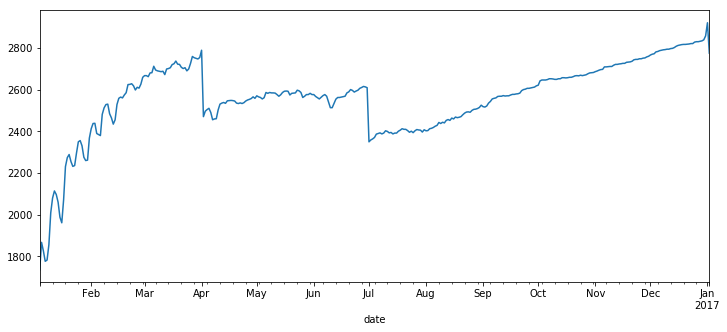

In [85]:
#Plotting average prices of apartments
print(available_df.index.min())
print(available_df.index.max())

available_df.resample('1D').count()['price'].plot()

In [11]:
# includes full descriptions and average review score

listings_df = pd.read_csv('data/listings.csv')
listings_df.info()
listings_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [21]:
print(np.sum(listings_df.isnull()))

id                                     0
listing_url                            0
scrape_id                              0
last_scraped                           0
name                                   0
summary                              177
space                                569
description                            0
experiences_offered                    0
neighborhood_overview               1032
notes                               1606
transit                              934
thumbnail_url                        320
medium_url                           320
picture_url                            0
xl_picture_url                       320
host_id                                0
host_url                               0
host_name                              2
host_since                             2
host_location                          8
host_about                           859
host_response_time                   523
host_response_rate                   523
host_acceptance_

In [12]:
# includes unique id for each reviewer and detailed comments

reviews_df = pd.read_csv('data/reviews.csv')
reviews_df.info()
reviews_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84832 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [5]:
#how many rows and columns in the calendar_df
print("No.of rows and columns in calendar_df : ", calendar_df.shape)

#how many rows and columns in the listings_df
print("No.of rows and columns in listings_df : ", listings_df.shape)

#how many rows and columns in the reviews_df
print("No.of rows and columns in reviews_df : ", reviews_df.shape)

No.of rows and columns in calendar_df :  (1393570, 4)
No.of rows and columns in listings_df :  (3818, 92)
No.of rows and columns in reviews_df :  (84849, 6)


In [6]:
# how many columns that have null values in each dataframe

calendar_df_no_nulls = set(calendar_df.columns[calendar_df.isnull().mean()==0])
listings_df_no_nulls = set(listings_df.columns[listings_df.isnull().mean()==0])
reviews_df_no_nulls = set(reviews_df.columns[reviews_df.isnull().mean()==0])

print(calendar_df_no_nulls)
print(len(calendar_df_no_nulls))
print(listings_df_no_nulls)
print(len(listings_df_no_nulls))
print(reviews_df_no_nulls)
print(len(reviews_df_no_nulls))


{'listing_id', 'available', 'date'}
3
{'host_id', 'jurisdiction_names', 'availability_30', 'city', 'street', 'number_of_reviews', 'latitude', 'availability_90', 'country', 'market', 'guests_included', 'extra_people', 'instant_bookable', 'scrape_id', 'bed_type', 'host_verifications', 'availability_60', 'cancellation_policy', 'host_url', 'room_type', 'price', 'has_availability', 'require_guest_profile_picture', 'amenities', 'name', 'availability_365', 'neighbourhood_cleansed', 'listing_url', 'longitude', 'requires_license', 'is_location_exact', 'experiences_offered', 'neighbourhood_group_cleansed', 'state', 'description', 'require_guest_phone_verification', 'smart_location', 'maximum_nights', 'last_scraped', 'country_code', 'id', 'minimum_nights', 'calendar_last_scraped', 'calendar_updated', 'calculated_host_listings_count', 'picture_url', 'accommodates'}
47
{'reviewer_id', 'id', 'reviewer_name', 'listing_id', 'date'}
5


listing_id         0
date               0
available          0
price         459028
dtype: int64

t    934542
f    459028
Name: available, dtype: int64